In [3]:
import numpy as np
import hickle as hkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rs
import os
import sys
import boto3
import yaml

sys.path.append('../src/')
from utils import quick_viz as make
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Conclusions
- A total of 255 tiles are affected by haze.
- In areas where resegmentation did not help the predictions, we expect the features to play a role. This notebook visualizes 65 features for neighboring haze affected tiles where resegmentation appeared successful (pd_east) and unsuccessful (pd_west).
- Artifacts are most extreme for the following feature indices pd_east: `10, 17, 19, 20, 31` and pd_west: `17, 19, 20, 23, 25, 28, 29, 31, 32, 40`. 
- The top 40 features used in the current model includes feature `42` which had strong artifacts in pd_west

## Example: resegmentation is successful

### ARD

In [5]:
tile_idx_a = (1656, 1068)
tile_idx_b = (1657, 1068)
ard_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/ard/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_ard.hkl')
ard_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/ard/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_ard.hkl')
for i in range(0, 13):
    make.heat_combine_neighbors(ard_a, ard_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

In [7]:
tile_idx_a = (1656, 1068)
tile_idx_b = (1657, 1068)
feats_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/raw/feats/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_feats.hkl')
feats_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/raw/feats/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_feats.hkl')
feats_a = np.rollaxis(feats_a, 0, 3)
feats_a = np.rollaxis(feats_a, 0, 2)
feats_b = np.rollaxis(feats_b, 0, 3)
feats_b = np.rollaxis(feats_b, 0, 2)
feats_a.shape, feats_b.shape

((618, 614, 65), (618, 614, 65))

In [9]:
for i in range(0, 65):
    make.heat_combine_neighbors(feats_a, feats_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

/Users/jessica.ertel/github/plantation_classifier/notebooks/../src/utils/quick_viz.py:271: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9,3))


Error in callback <function _draw_all_if_interactive at 0x166fcaef0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x16f992680> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



## Example: resegmentation is unsuccessful

### ARD

In [11]:
# tile_idx_a = (1647, 1079)
# tile_idx_b = (1648, 1079)
# ard_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/ard/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_ard.hkl')
# ard_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/ard/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_ard.hkl')
# for i in range(0, 5):
#     make.heat_combine_neighbors(ard_a, ard_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

### Features

In [34]:
tile_idx_a = (1647, 1079)
tile_idx_b = (1648, 1079)
feats_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/raw/feats/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_feats.hkl')
feats_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/raw/feats/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_feats.hkl')
feats_a = np.rollaxis(feats_a, 0, 3)
feats_a = np.rollaxis(feats_a, 0, 2)
feats_b = np.rollaxis(feats_b, 0, 3)
feats_b = np.rollaxis(feats_b, 0, 2)
feats_a.shape, feats_b.shape

((618, 614, 65), (618, 614, 65))

In [40]:
# for i in range(0, 65):
#     make.heat_combine_neighbors(feats_a, feats_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

## Which features should be targeted?

In [38]:
east = [10, 17, 19, 20, 31]
west = [17, 19, 20, 23, 25, 28, 29, 31, 32, 40]
east = [i+13 for i in east]
west = [i+13 for i in west]
east, west

([23, 30, 32, 33, 44], [30, 32, 33, 36, 38, 41, 42, 44, 45, 53])

top features for v25.5 model (current): `0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 18, 20, 21, 24, 34, 42, 50, 52, 59, 60, 62, 63, 64, 65, 70, 71, 72, 73, 74, 76, 77, 84, 89, 90, 93`

In [13]:
north = pd.read_csv('../data/database/haze_pd_north.csv')
east = pd.read_csv('../data/database/haze_pd_east.csv')
west = pd.read_csv('../data/database/haze_pd_west.csv') 
artifacts = pd.concat([north, east, west], axis=0, ignore_index=True)
#artifacts.to_csv('../data/database/haze_artifacts_full.csv')

In [6]:
artifacts.head()

,X,Y,Y_tile,X_tile,country,ADM2_EN,ADM1_EN,ADM0_EN,validOn,Area_ha,n,distance,feature_x,feature_y,nearest_x,nearest_y
0,-1.8611,10.9722,1161,1652,Ghana,Sissala East,Upper West,Ghana,2021/03/08,509357.138147,1,0.0,-1.8611,10.9722,-1.8611,10.9722
1,-1.8056,10.9722,1161,1653,Ghana,Sissala East,Upper West,Ghana,2021/03/08,509357.138147,1,0.0,-1.8056,10.9722,-1.8056,10.9722
2,-1.7500,10.9722,1161,1654,Ghana,Sissala East,Upper West,Ghana,2021/03/08,509357.138147,1,0.0,-1.7500,10.9722,-1.7500,10.9722
3,-1.3056,10.9722,1161,1662,Ghana,Kasena Nankana West,Upper East,Ghana,2021/03/08,87319.983711,1,0.0,-1.3056,10.9722,-1.3056,10.9722
4,-1.3611,10.9167,1160,1661,Ghana,Kasena Nankana West,Upper East,Ghana,2021/03/08,87319.983711,1,0.0,-1.3611,10.9167,-1.3611,10.9167


In [26]:
total_differences = np.zeros((len(artifacts), 65))

counter = 0

for i, val in artifacts.iterrows():
    left_x = val['X_tile']
    left_y = val['Y_tile']
    right_x = int(left_x) + 1
    right_y = int(left_y)
    check_neighbor = artifacts[(artifacts['X_tile'] == right_x) & (artifacts['Y_tile'] == right_y)] 
    if not check_neighbor.empty:
        #print(f"Calculating diff for {left_x, left_y} and {right_x, right_y}")
        folder = f'../tmp/ghana/'
        left = hkl.load(f'{folder}{str(left_x)}/{str(left_y)}/raw/feats/{str(left_x)}X{str(left_y)}Y_feats.hkl')
        right = hkl.load(f'{folder}{str(right_x)}/{str(right_y)}/raw/feats/{str(right_x)}X{str(right_y)}Y_feats.hkl')
        lboundary = left[:, :, -2:]
        rboundary = right[:, :, :2]
        # Calculate the range for each feature
        f_range = np.max(np.concatenate((lboundary, rboundary), axis=2), axis=(1, 2)) - np.min(np.concatenate((lboundary, rboundary), axis=2), axis=(1, 2))
        
        # Calculate the normalized difference across the boundary for each feature
        boundary_diff = np.mean(abs(lboundary - rboundary) / (np.mean(lboundary + rboundary) / 2), axis=(1, 2))
        
        # Normalize the normalized difference by the feature range
        norm_diff = boundary_diff / f_range

        # Store the result in total_differences
        total_differences[counter] = norm_diff
        
        counter += 1


# for each neighboring tile pair, what is the normalized difference
# across the border between the pairs for each feature index
# higher values are sharper artifacts

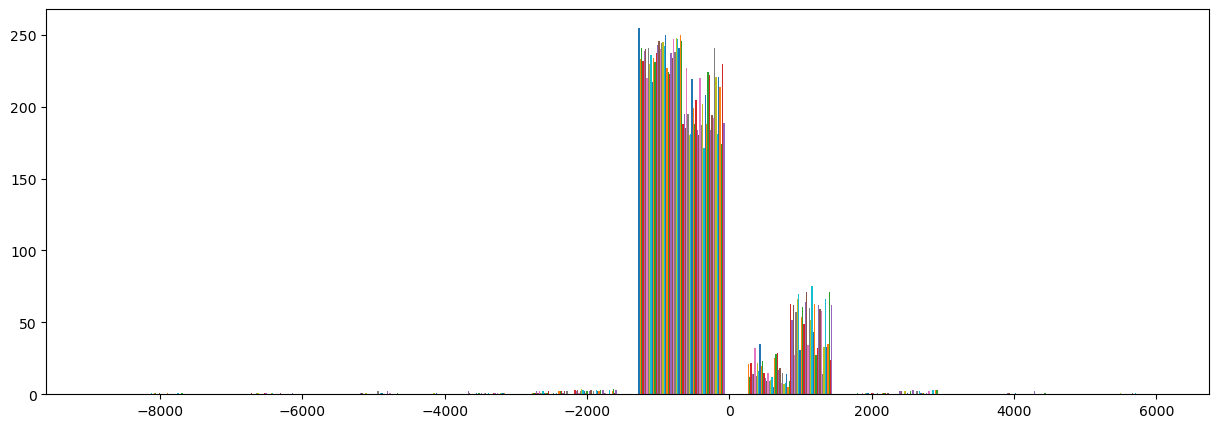

In [25]:
# not normalized
plt.figure(figsize=(15,5))
plt.hist(total_differences);

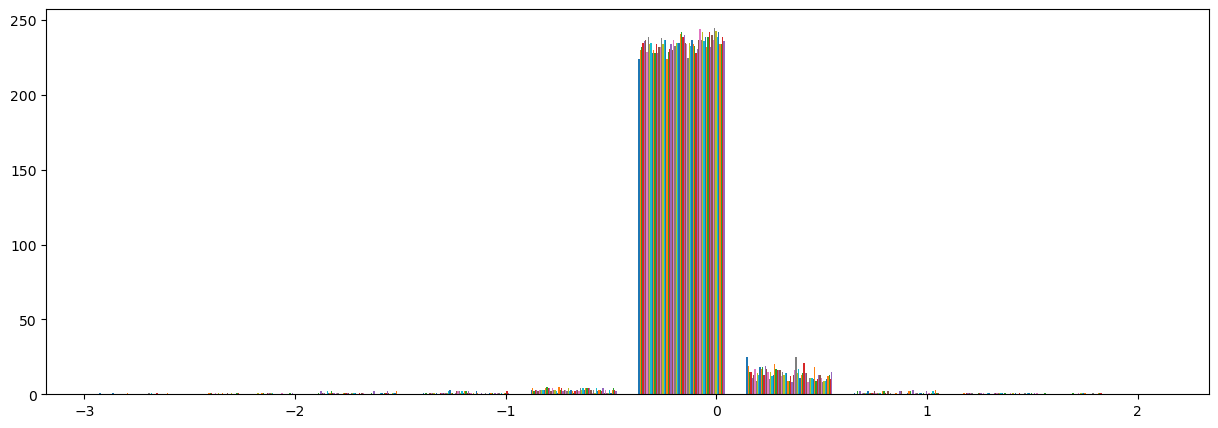

In [28]:
## normalized
plt.figure(figsize=(15,5))
plt.hist(total_differences);